In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import Timedelta
from datetime import datetime, timezone
plt.rcParams['figure.figsize'] = [16, 4]
pd.options.display.float_format = '{:_.9f}'.format

tic_file = '/Users/dorsic/Documents/PhD/Measurements/SMU-2022-09-24/Week2/smu_2022-09.txt'
tic_out_file = '/Users/dorsic/Documents/PhD/Measurements/SMU-2022-09-24/Week2/processed/SMU_Cs10M_vs_RCB-F9T_cm2.txt'
tic_out_lnsq_file = '/Users/dorsic/Documents/PhD/Measurements/SMU-2022-09-24/Week2/processed/SMU_Cs10M_vs_RCB-F9T_cm2_lnsq.txt'
tic_lim = (None, None)
tic_scale = 1.0   # multiply values to get them to nanoseconds

# tic_file = '/Users/dorsic/Documents/PhD/Measurements/SMU-2022-09-24/Week2/gpib_readings.txt'
# tic_out_file = '/Users/dorsic/Documents/PhD/Measurements/SMU-2022-09-24/Week2/processed/SMU_Cs10M_vs_RCB-F9T_hp.txt'
# tic_out_lnsq_file = '/Users/dorsic/Documents/PhD/Measurements/SMU-2022-09-24/Week2/processed/SMU_Cs10M_vs_RCB-F9T_hp_lnsq.txt'
# tic_lim = (6000, None)
# tic_scale = 1.0e9   # multiply values to get them to nanoseconds

ublox_datafolder = '/Users/dorsic/Documents/PhD/Measurements/SMU-2022-09-24/Week2/ublox/'
mjd_range = range(59845, 59863)

leapsec = 18
ubxcycle = 7.8125 # period in ns of the u-blox NCO at 128 MHz
ubxcycle = 4.096 # period in ns of the u-blox NCO at 128 MHz
ubxcycle = 4.7 # 10.24/2
xlim, ylim, xtics = None, None, None

Matplotlib created a temporary config/cache directory at /var/folders/nh/hhc5vw354hn0pd15b50rcpcc0000gn/T/matplotlib-_uy6u7_x because the default path (/Users/dorsic/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


### TIM-TP data loading and preprocessing

In [2]:
tps = []
for filename in [ublox_datafolder+'timepulse-'+str(mjd)+'.txt' for mjd in mjd_range]:
    tp = pd.read_csv(filename, header=0, delimiter='\t', index_col=None)
    tp['DATE'] = tp.TS.apply(lambda x: datetime.fromtimestamp(x+leapsec, timezone.utc))
    tp['QERR'] = tp['QERR']*1.0e-3
    tps.append(tp)

df_tp = pd.concat(tps, axis=0, ignore_index=True)
df_tp.set_index('DATE', drop=False, inplace=True)
df_tp.head(5)


,LCL,TS,MJD,QERR,TIMEBASE,DATE
DATE,,,,,,
2022-09-23 07:18:44+00:00,1_663_917_487.382198095,1_663_917_506.000000000,59_845.304259259,-2.296000000,GPS,2022-09-23 07:18:44+00:00
2022-09-23 07:18:45+00:00,1_663_917_488.376266956,1_663_917_507.000000000,59_845.304270833,-3.982000000,GPS,2022-09-23 07:18:45+00:00
2022-09-23 07:18:46+00:00,1_663_917_489.380932093,1_663_917_508.000000000,59_845.304282407,1.867000000,GPS,2022-09-23 07:18:46+00:00
2022-09-23 07:18:47+00:00,1_663_917_490.379684925,1_663_917_509.000000000,59_845.304293981,0.003000000,GPS,2022-09-23 07:18:47+00:00
2022-09-23 07:18:48+00:00,1_663_917_491.386236906,1_663_917_510.000000000,59_845.304305556,-1.748000000,GPS,2022-09-23 07:18:48+00:00


In [3]:
# remove bad data at the end if any
df_tp = df_tp[:]
# if no duplicit tim-tp in a second add missing rows
idx = pd.date_range(df_tp.index[0], df_tp.index[-1], freq='s')
df_tp = df_tp.reindex(idx, copy=True)
df_tp.sort_index(inplace=True)
#df_tp['DOM'] = (df_tp.DATE-df_tp.iloc[0].DATE.replace(hour=0, minute=0, second=0, microsecond=0)).apply(lambda x: x.days)
#df_tp['TOD'] = tp.DATE.apply(lambda x: x.second + x.minute*60 + x.hour * 3600 + x.microsecond*1.0e-6)
idx = pd.Series(df_tp.index, index=df_tp.index)
df_tp['TOD'] = idx.dt.hour*3600 + idx.dt.minute*60 + idx.dt.second
df_tp['DOM'] = (df_tp.index-df_tp.iloc[0].DATE.replace(hour=0, minute=0, second=0, microsecond=0)).days

List missing qErr readings

In [4]:
df_tp.loc[df_tp['TS'].isna()]


,LCL,TS,MJD,QERR,TIMEBASE,DATE,TOD,DOM
2022-09-30 07:15:05+00:00,NaN,NaN,NaN,NaN,NaN,NaT,26105,7
2022-10-01 03:24:16+00:00,NaN,NaN,NaN,NaN,NaN,NaT,12256,8
2022-10-10 13:03:52+00:00,NaN,NaN,NaN,NaN,NaN,NaT,47032,17
2022-10-10 13:10:35+00:00,NaN,NaN,NaN,NaN,NaN,NaT,47435,17


### Time Interval Counter data loading and preprossing

,TI,LCL
0,144.162000000,1_663_917_915.022093058
1,141.732000000,1_663_917_916.027158976
2,147.241000000,1_663_917_917.027111053
3,144.791000000,1_663_917_918.027122974
4,142.221000000,1_663_917_919.027121067


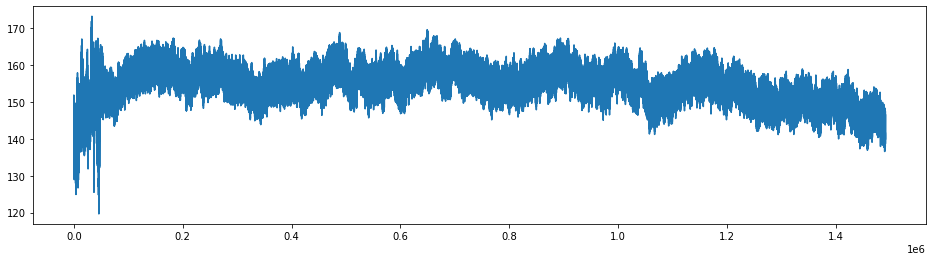

In [5]:
df = pd.read_csv(tic_file, sep='\t', header=None, skiprows=tic_lim[0])
df.rename(columns={0: 'TI', 1: 'LCL'}, inplace=True)
if tic_lim[1]:
    df = df[:tic_lim[1]].copy()
df['TI'] = df.TI * tic_scale
steps = 0       # number of wraps of the local clock
df[:].TI.plot()
df.head(5)

Have local timestamps some frequency offset?

Assume the u-blox or Cs standard triggering the measurement, so every measurement must be +- 1s appart.
Look for missing data samples.

f= 1.0000010944049584  Hz


<AxesSubplot:>

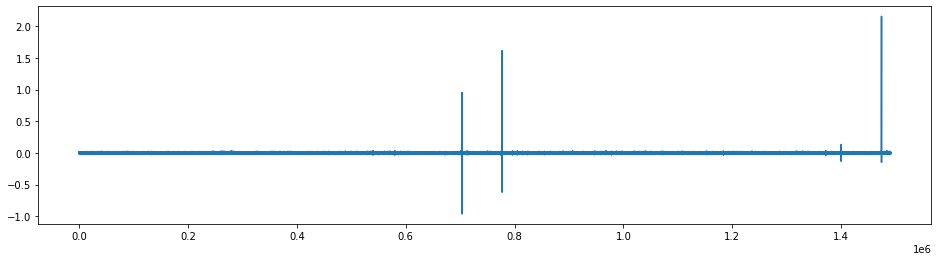

In [6]:
foffset = np.polyfit(df.index, df.LCL, 1)[0]
print('f=', foffset, ' Hz', )

df["dLCL"] = df.LCL.diff() - 1
xlim = None
df.dLCL.plot(xlim=xlim)

<AxesSubplot:>

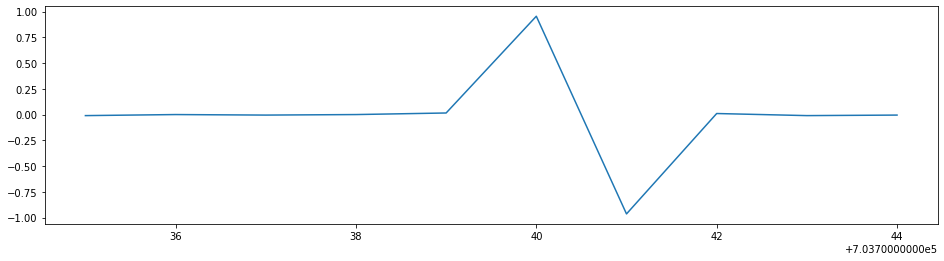

In [7]:
#matplotlib.rcParams['figure.figsize'] = [width, height]
# look closer on the LCL timestamps
center = 703740 #777140 # 703740
hinterv = 5
df[center-hinterv:center+hinterv].dLCL.plot()


##### Count steps in the data and try to find the frequency offset

In [92]:
# unstep local clock; 328 is number of steps in 1M seconds
# you can get it by 
#foffset = np.polyfit(df.index, df.LCL, 1)[0]
#print(foffset)
# -0.4 is time offset so all data stayies within fractions of a second
# 250088 is the last index, where serial diff is greated then 1 second


steps, approaching, min_step_dist, dist = 0, False, 1000, 0
for index, row in df[0:1000000].iterrows():
    if (row.LCL-int(row.LCL) < 0.5) and (dist > min_step_dist):
        approaching = True
    if (approaching and (row.LCL-int(row.LCL)) > 0.9):
        steps += 1
        print("Step at", index)
        dist = 0
        approaching = False
    dist += 1
print(steps)
#a = df.LCL[:].apply(lambda x: x-int(x)).diff()
#a[350000:355000].rolling(2).mean().plot(figsize=(15,3), style=".")
#df.LCL[:].apply(lambda x: x-int(x)).diff().plot(figsize=(15,3))
#df[251465:].head(10)

# we have 328 steps in 1000000 rows of the data

Step at 703740
1


##### Reindex data and add null values for missing 1 second measurements

<AxesSubplot:title={'center':'Cs timescale vs RPi timescale'}, ylabel='dt [ns]'>

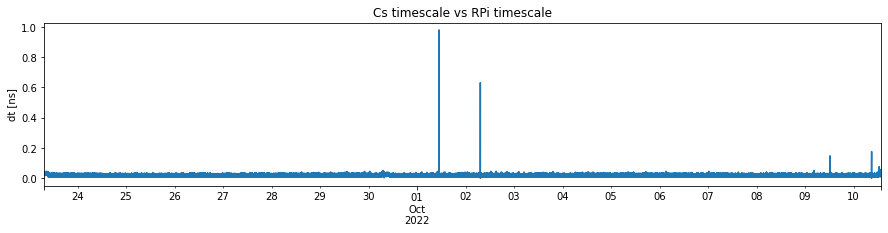

In [7]:
df = df[:]
start_ts = df.iloc[0].LCL
# correct the local time scale from frequency offset. Assuming the measuremets are ticked by CS or GNSS
df['TS'] = start_ts+(df.LCL-start_ts)*(1.0+steps/1e6)
#df['TS'] = df.LCL*(1-foffset)-0.5
df['DATE'] = df.TS.apply(lambda x: datetime.fromtimestamp(np.int64(x+leapsec), timezone.utc) if pd.notna(x) else pd.NaT)
df.set_index('DATE', drop=False, inplace=True)
idx = pd.date_range(df.index[0], df.index[-1], freq='s')
df = df.reindex(idx, copy=True)
idx = pd.Series(df.index, index=df.index)
df['TOD'] = idx.dt.hour*3600 + idx.dt.minute*60 + idx.dt.second
df['DOM'] = (df.index-df.iloc[0].DATE.replace(hour=0, minute=0, second=0, microsecond=0)).days
#df['TOD'] = df.DATE.apply(lambda x: x.second + x.minute*60 + x.hour * 3600 + x.microsecond*1.0e-6)
#df['DOM'] = (df.DATE-df.iloc[0].DATE.replace(hour=0, minute=0, second=0, microsecond=0)).apply(lambda x: x.days)
df.head(5)

a = df.TS.apply(lambda x: x-int(x) if pd.notna(x) else 0)
a.plot(figsize=(15,3), ylabel='dt [ns]', title='Cs timescale vs RPi timescale')

### Apply quantization error correction

#### Analysis, do not run.

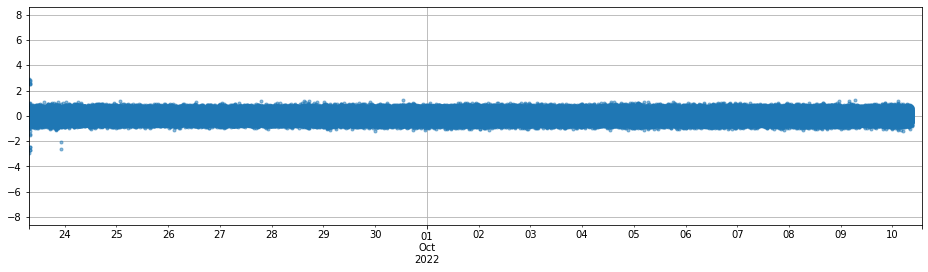

In [127]:
#xlim = (59776.3, 59776.35)
fist_val = 10
ilim = (first_val+40000, first_val+80000)
ylim=(35,55)
#ax1 = df_q[ilim[0]:ilim[1]].plot.scatter(x='MJD', y='QERR_sft', c='grey', s=2, alpha=0.9)
#df_q[ilim[0]:ilim[1]].plot.scatter(x='MJD', y='TI_Q', c='blue', s=3, alpha=0.9, figsize=(15,3), grid=True, ax=ax1, xlim=xlim, ylim=ylim)
vals = [7.8125, 4.7]
hlines = [(y, -y) for y in vals]
ax1 = df_q.TI_Q.diff().plot(style='.', alpha=0.5, grid=True)
ax1.hlines(y=hlines, xmin=ilim[0], xmax=ilim[1], color='r')


#### qErr correction by dataframes merging

shift 0:777139 for qerr: -18
shift 777140:1474134 for qerr: -17


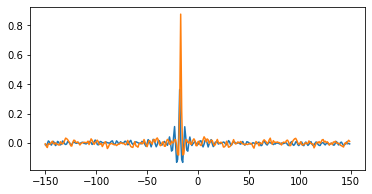

In [8]:
# merge dataframes and apply qerr corrections
# find any breaks in the data and for each block of data compute the shift to qerr dataframe and apply it separately

df_q = pd.merge_asof(df, df_tp, left_index=True, right_index=True, direction='backward', suffixes=('', '_tp'), tolerance=Timedelta(microseconds=500000))
df_q['TI_Q'] = np.NaN
idxrange = range(-150, 150)
first_val = df_q.index.get_loc(df_q.TS_tp.first_valid_index())
naindices = df_q.loc[df_q.TI.isna()].index.to_list()
if len(naindices) == 0:
    naindices=[df_q.index[-1]]
for naidx in naindices:
    # find correct shift
    naidxloc = df_q.index.get_loc(naidx)
    nalength = naidxloc-first_val if naidxloc-first_val < 10000 else 10000
    if nalength > 1:
        cq = pd.Series(idxrange, index=idxrange).apply(lambda x: df_q[first_val:first_val+nalength].TI.corr(df_q.QERR.shift(x)))
        cq.plot(figsize=(6,3), label=f'shift {first_val}:{first_val+nalength}')
        sft = cq.idxmax()
        print(f"shift {first_val}:{naidxloc} for qerr: {sft}")
        df_q.iloc[first_val:naidxloc, df_q.columns.get_loc('TI_Q')] = (df_q.TI - df_q.QERR.shift(sft, fill_value=0.0)).iloc[first_val:naidxloc]
        first_val = naidxloc+1
#integer position of first merged value present in both datasets

<AxesSubplot:xlabel='MJD', ylabel='TI_Q'>

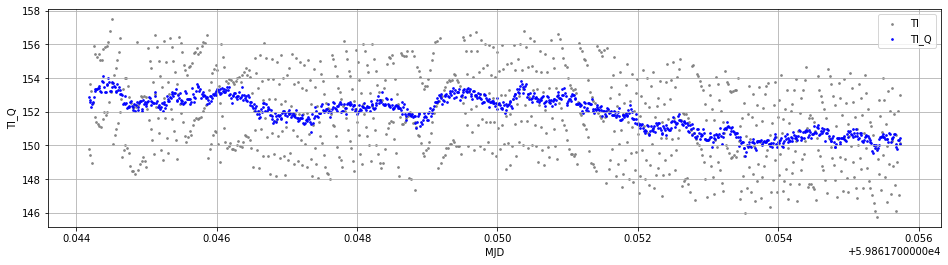

In [9]:
# verify by plotting the data
plot_offset=1420000
first_val = 10
ilim=(plot_offset, plot_offset+1000)
ax1 = df_q[ilim[0]:ilim[1]].plot.scatter(x='MJD', y='TI', c='grey', s=3, alpha=0.9, label='TI')
df_q[ilim[0]:ilim[1]].plot.scatter(x='MJD', y='TI_Q', c='blue', s=3, alpha=0.9, xticks=xtics, grid=True, ax=ax1, xlim=xlim, ylim=ylim, label='TI_Q')

<AxesSubplot:>

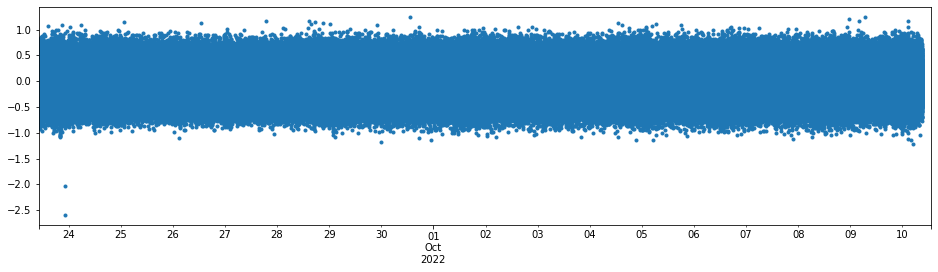

In [10]:
df_q['dTI_Q'] = df_q['TI_Q'].diff()
df_q[10000:-1000].dTI_Q.plot(style='.')

#### Compute cycle correction and outlayers

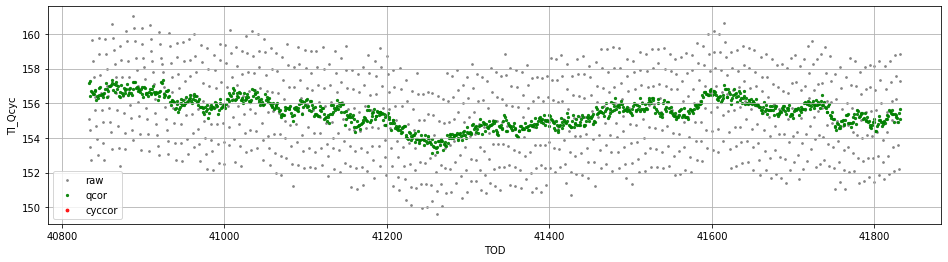

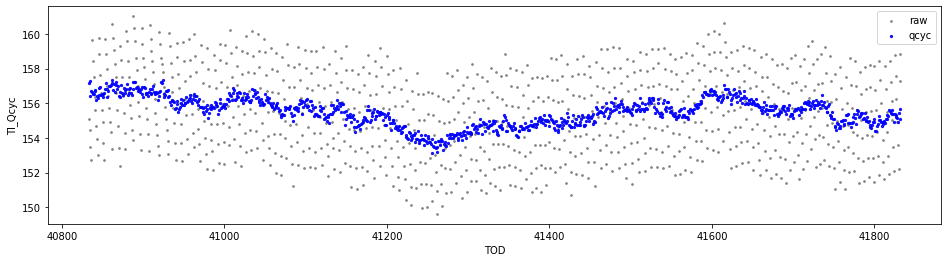

In [11]:
df = df_q.copy()
df['TI_Qcyc'] = df['TI_Q']
for i in range(3):  # can iteratively clean 3 outliers in a row
    df['TI_Qcyc'] = df.TI_Qcyc.mask(df.TI_Qcyc.diff()>3.8, df.TI_Qcyc - ubxcycle)
ilim=(100500, 101500)
ax1 = df[ilim[0]:ilim[1]].plot.scatter(x='TOD', y='TI', c='grey', s=3, alpha=0.9, label='raw')
ax2 = df[ilim[0]:ilim[1]].plot.scatter(x='TOD', y='TI_Q', c='g', s=5, alpha=0.9, ax=ax1, label='qcor')
#ax3 = df[ilim[0]:ilim[1]].plot.scatter(x='TOD', y='TI_Qcyc', c='b', s=2, alpha=0.9, ax=ax1, label='qcyc')
df[ilim[0]:ilim[1]].loc[df[ilim[0]:ilim[1]].TI_Q.diff()>3.8].plot.scatter(x='TOD', y='TI_Qcyc', c='r', s=8, alpha=0.9, 
    xticks=xtics, grid=True, xlim=xlim, ylim=ylim, ax=ax1, label='cyccor')

ax1 = df[ilim[0]:ilim[1]].plot.scatter(x='TOD', y='TI', c='grey', s=3, alpha=0.9, label='raw')
ax2 = df[ilim[0]:ilim[1]].plot.scatter(x='TOD', y='TI_Qcyc', c='b', s=5, alpha=0.9, ax=ax1, label='qcyc')
#df[ilim[0]:ilim[1]].loc[df[ilim[0]:ilim[1]].TI_Q.diff()>5.0].plot.scatter(x='TOD', y='TI_Qcyc', c='r', s=8, alpha=0.9, 
   # figsize=(15,3), xticks=xtics, grid=True, xlim=xlim, ylim=ylim, ax=ax1, label='cyccor')

May be use averaging instead of quantum corrections?

YES

3-sigma filter may be useless

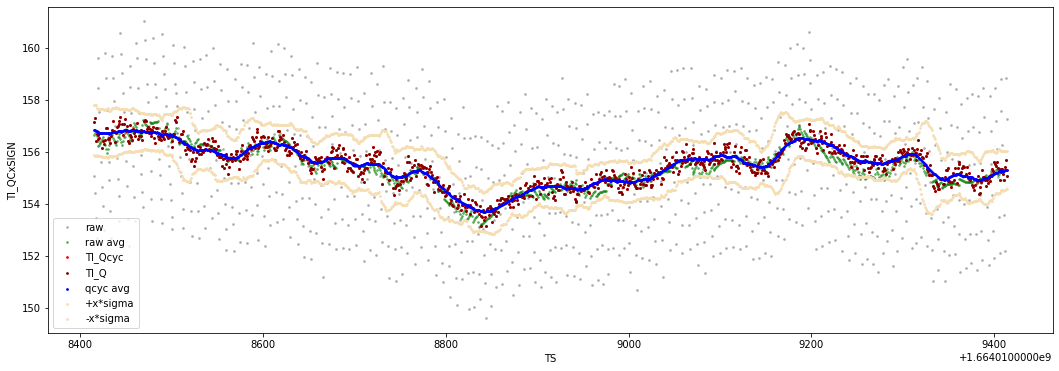

In [12]:
#[['TI', 'TI_QERR']]
dfm = df
dfm['TI_30AVG'] = dfm.TI.rolling(30, center=True).mean()
dfm['TI_QC30AVG'] = dfm.TI_Qcyc.rolling(30, center=True).mean()
dfm['TI_QC30STD'] = dfm.TI_Qcyc.rolling(30, center=True).std()
dfm['TI_QCxSIGP'] = dfm.TI_QC30AVG + 3*dfm.TI_QC30STD
dfm['TI_QCxSIGN'] = dfm.TI_QC30AVG - 3*dfm.TI_QC30STD
ax1 = dfm[ilim[0]:ilim[1]].plot.scatter(x='TS', y='TI', c='gray', s=3,  alpha=0.5, figsize=(18,6), label='raw')
ax2 = dfm[ilim[0]:ilim[1]].plot.scatter(x='TS', y='TI_30AVG', c='green', s=3,  alpha=0.5, ax = ax1, label='raw avg')
ax4 = dfm[ilim[0]:ilim[1]].plot.scatter(x='TS', y='TI_Qcyc', s=3, c='red', ax=ax1, label='TI_Qcyc')
ax3 = dfm[ilim[0]:ilim[1]].plot.scatter(x='TS', y='TI_Q', s=3, c='maroon', ax=ax1, label='TI_Q')
ax5 = dfm[ilim[0]:ilim[1]].plot.scatter(x='TS', y='TI_QC30AVG', c='blue', s=3, ax=ax1, label='qcyc avg')
ax6 = dfm[ilim[0]:ilim[1]].plot.scatter(x='TS', y='TI_QCxSIGP', c='wheat', s=3, ax=ax1, label='+x*sigma')
ax7 = dfm[ilim[0]:ilim[1]].plot.scatter(x='TS', y='TI_QCxSIGN', c='wheat', s=3, ax=ax1, label='-x*sigma')

In [13]:
df.to_csv(tic_out_file, sep='\t', index=False, columns=['TI_Qcyc', 'DATE', 'MJD', 'LCL', 'TS', 'DOM', 'TOD', 'TI', 'QERR', 'TI_Q', 'TI_30AVG', 'TI_QC30AVG', 'TI_QC30STD', 'TIMEBASE', 'DATE_tp', 'TOD_tp', 'DOM_tp'])

import fileinput
with fileinput.FileInput(tic_out_file, inplace=True) as file:
    for line in file:
        print(line.replace('+00:00', ''), end='')

### DAY BY DAY ANALYSIS

compute daily least square regressions where A*<TOD> + B = <TI_Qcyc> and 0*<TOD> + C = <TI_Qcyc> (so a constant line)
Rsq are average linear squared residuals, RCsq are average squared residuals from the contant C

In [14]:
doms = df.loc[df['DOM'].notna()]['DOM'].astype('int').unique()
res = []
for dom in doms:
    ddf = df.loc[(df['DOM'] == dom) & (df['TI_Qcyc'].notna())].copy()
    n = len(ddf)
    # do least squares linear regression
    lnsqA = np.vstack([ddf.TOD, np.ones(n)]).T
    lnsq = np.linalg.lstsq(lnsqA, ddf.TI_Qcyc, rcond=None)

    # find a constant for which are the residuals minimal
    lnsqA = np.vstack([[0]*n, np.ones(n)]).T
    lnsq_c = np.linalg.lstsq(lnsqA, ddf.TI_Qcyc, rcond=None)
    # this is the residuals from a contant lnsq_c[0][1]
    lnsq_cr = ((ddf['TI_Qcyc']-lnsq_c[0][1])**2).sum()

    res.append((dom, lnsq[0][0], lnsq[0][1], lnsq[1][0]/n, lnsq_c[0][1], lnsq_cr/n))
df_lnsq = pd.DataFrame(res, columns=['DOM', 'A', 'B', 'Rsq', 'C', 'RCsq'])
df_lnsq

,DOM,A,B,Rsq,C,RCsq
0,0,0.000206489,137.110696986,45.682267044,148.790941928,58.331963989
1,1,0.000110611,151.269327236,2.518542062,156.047645556,10.129493561
2,2,-0.000037733,159.973723214,3.705596698,158.343669502,4.591308901
3,3,-0.000036155,158.415479435,2.581378573,156.853605035,3.394547944
4,4,0.000057597,151.621598321,2.459498913,154.109769306,4.523211634
5,5,0.000083655,152.964186739,3.650489749,156.578022824,8.003860936
6,6,-0.000016744,156.877576271,4.845560960,156.154264630,5.019958240
7,7,0.000064963,154.880127423,5.171754584,157.686516788,7.797081120
8,8,-0.000028589,159.474052811,3.432578251,158.239020972,3.941012949
9,9,-0.000001427,154.750281784,2.445074911,154.688639753,2.446341516


In [15]:
df_lnsq.to_csv(tic_out_lnsq_file, sep='\t', index=False)

Text(0.5, 1.0, 'RCB-F9T vs CsIII (Compute Module 2)')

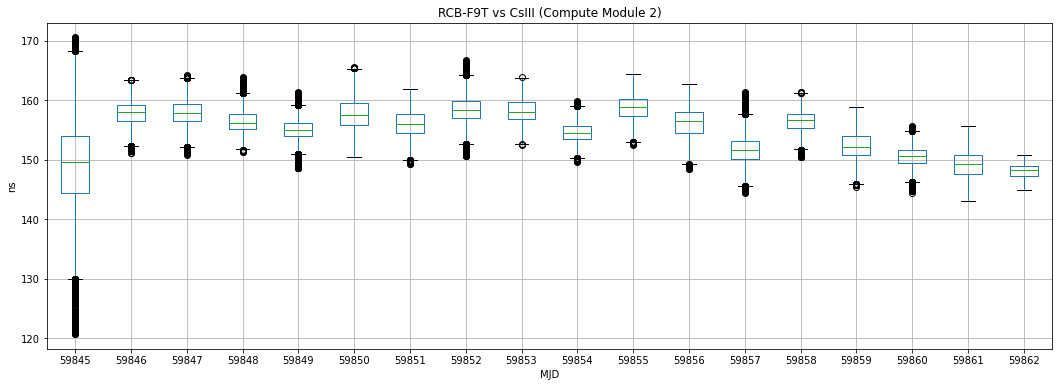

In [18]:
ddf = pd.DataFrame()
doms = df.loc[df['DOM'].notna()]['DOM'].astype('int').unique()
for dom in doms:
    ddf[f'D{dom}'] = df.loc[df['DOM'] == dom].set_index('TOD')['TI_Qcyc']
    

mjds = df.loc[df['MJD'].notna()]['MJD'].astype('int').unique()
crnm = {}
for i in range(len(doms)):
    crnm[f'D{doms[i]}'] = mjds[i] 
ddf.rename(columns=crnm, inplace=True)

ax = ddf.boxplot(column=ddf.columns[0:].to_list(), figsize=(18,6))
ax.set_ylabel('ns')
ax.set_xlabel('MJD')
ax.set_title('RCB-F9T vs CsIII (Compute Module 2)')
#ax.set_title('RCB-F9T vs CsIII (HP53131A)')

In [20]:
df.loc[df_q.TOD.isna()]

,TI,LCL,dLCL,TS,DATE,TOD,DOM,LCL_tp,TS_tp,MJD,...,TOD_tp,DOM_tp,TI_Q,dTI_Q,TI_Qcyc,TI_30AVG,TI_QC30AVG,TI_QC30STD,TI_QCxSIGP,TI_QCxSIGN
